In [221]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import os
import sys
from PIL import Image
import pipeline
import tensorflow as tf

## Load data

In [222]:
# masks = glob.glob("../input/isbi2015/train/label/*.png")
# orgs = glob.glob("../input/isbi2015/train/image/*.png")

In [223]:
# imgs_list = []
# masks_list = []
# for noise, labels in dataset:
#     imgs_list.append(noise.numpy())
#     masks_list.append(labels.numpy())
    

# imgs_np = np.asarray(imgs_list)
# masks_np = np.asarray(masks_list)

In [224]:
# print(imgs_np.shape, masks_np.shape)

## Plot images + masks + overlay (mask over original)

In [225]:
from keras_unet.utils import plot_imgs
# plot_imgs(org_imgs=imgs_np, mask_imgs=masks_np, nm_img_to_plot=10, figsize=6)


## Get data into correct shape, dtype and range (0.0-1.0)

In [226]:

#print(imgs_np.max(), masks_np.max())

dataset = pipeline.Pipeline(file='CDStent.raw').dataset #création de notre dataset
x = []
y = []
for noised_images, labels in dataset:
        x.append(noised_images.numpy())
        y.append(labels.numpy())

In [227]:
x = np.array(x, dtype=np.float32)
y = np.array(y, dtype=np.float32)

In [228]:
print(x.max(), y.max())

1.0 1.0


In [229]:
print(x.shape, y.shape)

(36, 512, 512, 1) (36, 512, 512, 1)


In [230]:
# plot_imgs(org_imgs=x, mask_imgs=y, nm_img_to_plot=10, figsize=6)

In [231]:
# y = y.reshape(y.shape[0], y.shape[1], y.shape[2], 1)
# print(x.shape, y.shape)

In [232]:
# x = x.reshape(x.shape[0], x.shape[1], x.shape[2], 1)
# print(x.shape, y.shape)

##  Train/val split

In [233]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.5, random_state=0)

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (18, 512, 512, 1)
y_train:  (18, 512, 512, 1)
x_val:  (18, 512, 512, 1)
y_val:  (18, 512, 512, 1)


## Prepare train generator with data augmentation

In [234]:
from keras_unet.utils import get_augmented

train_gen = get_augmented(
    x_train, y_train, batch_size=3,
    data_gen_args = dict(
        rotation_range=10.,
        # width_shift_range=0.05,
        # height_shift_range=0.05,
        # shear_range=50,
        # zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        # fill_mode='nearest'
    ))

(3, 512, 512, 1) (3, 512, 512, 1)


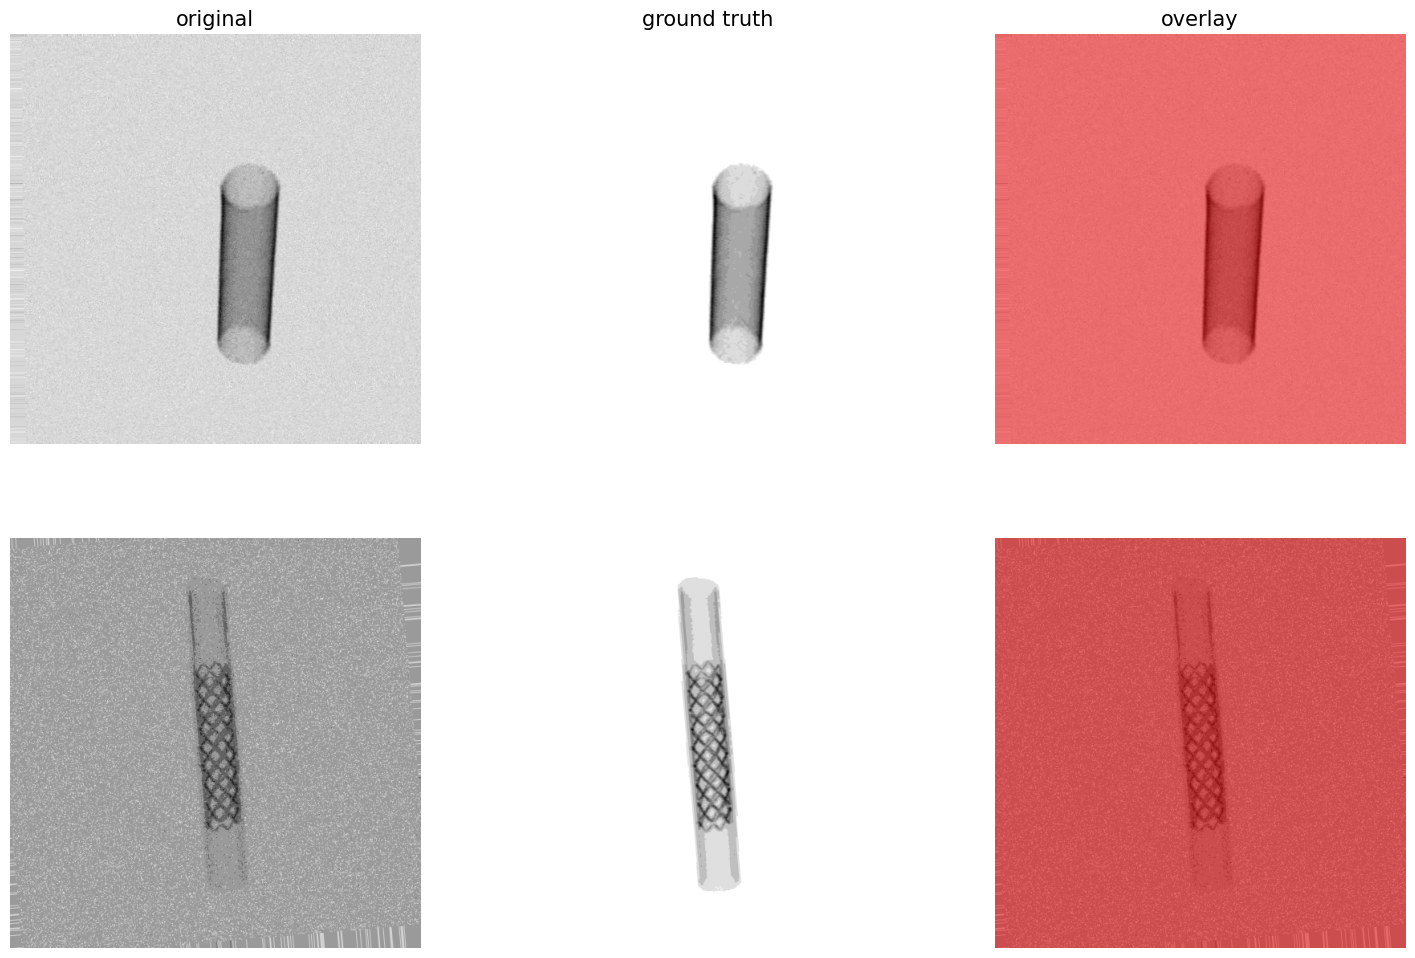

In [235]:
sample_batch = next(train_gen)

xx, yy = sample_batch
print(xx.shape, yy.shape)
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=xx, mask_imgs=yy, nm_img_to_plot=2, figsize=6)

## Initialize network

In [236]:
from models.custom_unet import custom_unet

input_shape = x_train[0].shape

model = custom_unet(
    input_shape,
    use_batch_norm=True,
    num_classes=1,
    filters=32,
    dropout=0.5,
    output_activation='relu' #à modifier selon Raja - anciennement sigmoid
)

In [237]:
# model.summary()

In [238]:
# import os
# os.environ["PATH"] += os.pathsep + "C:\\Program Files (x86)\\Graphviz2.38\\bin\\"

In [239]:
# import sys
# print(sys.path)

# sys.path.append("C:\\Program Files (x86)\\Graphviz2.38\\bin\\") 

# print(sys.path)

In [240]:
from keras_unet.utils import plot_model
# plot_model(model, to_file='model.png')

ImportError: cannot import name 'plot_model' from 'keras_unet.utils' (c:\Users\malic\Bureau\Projets scolaires\projet_s8_debruitage\keras_unet\utils.py)

## Compile + train

In [ ]:
from keras.callbacks import ModelCheckpoint


model_filename = 'segm_model2_v0.h5'
callback_checkpoint = ModelCheckpoint(
    model_filename, 
    verbose=1, 
    monitor='val_loss', #pas besoin de modifier, cette fonction prend la loss fixée par model.compile
    save_best_only=True,
)

In [ ]:
from keras.optimizers import Adam, SGD
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance
# from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.metrics import mean_absolute_error, mean_squared_error

model.compile(
    # optimizer=SGD(learning_rate=0.01, momentum=0.99),
    optimizer=Adam(beta_1 = 0.9, beta_2 = 0.999, epsilon=1e-10, learning_rate=1e-2),
    loss='MSE', #anciennement : 'binary_crossentropy'. J'ai ajouté MSE dans le fichier loss, je sais pas si ça fonctionnera. 
    #Ce sont des loss fonctions et pas des scores. Je pourrai plus tard mettre d'autres metrics. 
    #loss=jaccard_distance,
    metrics=[mean_squared_error, mean_absolute_error] #anciennement iou et val_iou. Je n'ai pas ajouté ces fonctins dans metrics. 
)


In [ ]:

# # # ! environ 2 min pour 10 epochs parmi les 100 ---> environ 3h pour tout entrainer
# history = model.fit(
#     train_gen,
#     steps_per_epoch=100,
#     epochs=10,
#     validation_data=(x_val, y_val),
#     callbacks=[callback_checkpoint])


## Plot training history

In [ ]:
# from keras_unet.utils import plot_segm_history

# plot_segm_history(history)

## Plot original + ground truth + pred + overlay (pred on top of original)

In [ ]:
# model.load_weights(model_filename)
# y_pred = model.predict(x_val)

In [ ]:
# from keras_unet.utils import plot_imgs

# plot_imgs(org_imgs=x_val, mask_imgs=y_val, pred_imgs=y_pred, nm_img_to_plot=9)